# Predict water temperature using LSTM models

Use the code from LSTM_Tutorial.ipynb to predict water temperature

In [1]:
# univariate data preparation
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import myLibrary as mL

### Get NDBC data

In [2]:
STATION_ID = "42036"    # 33.61% NaN values -> Best value for GOM and 2022
YEAR = "2022"

In [3]:
data = mL.get_buoy_data(STATION_ID, YEAR)
data

,WDIR_42036,WSPD_42036,WVHT_42036,APD_42036,MWD_42036,PRES_42036,ATMP_42036,WTMP_42036,DEWP_42036
timestamp,,,,,,,,,
2022-01-01 00:00:00,168.0,3.5,NaN,NaN,NaN,1016.3,23.3,23.0,23.3
2022-01-01 01:00:00,166.0,4.5,NaN,NaN,NaN,1016.6,23.2,23.0,23.2
2022-01-01 02:00:00,171.0,5.4,NaN,NaN,NaN,1017.0,23.2,23.0,23.2
2022-01-01 03:00:00,170.0,5.2,NaN,NaN,NaN,1017.1,23.2,23.0,23.2
2022-01-01 04:00:00,169.0,5.7,NaN,NaN,NaN,1017.1,23.2,23.0,23.2
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,147.0,7.9,NaN,NaN,NaN,1016.2,21.3,22.0,20.9
2022-12-31 20:00:00,164.0,6.1,NaN,NaN,NaN,1016.1,21.5,22.0,21.2
2022-12-31 21:00:00,187.0,4.9,NaN,NaN,NaN,1016.6,22.2,22.1,21.4


In [4]:
data = data.drop([
    "WDIR_42036",
    "WSPD_42036",
    "WVHT_42036",
    "APD_42036",
    "MWD_42036",
    "PRES_42036",
    "ATMP_42036",
    #"WTMP_42036",
    "DEWP_42036"], axis=1)
data

,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


In [5]:
print("NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

NaN values:  57


In [6]:
data.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

Remaining NaN values:  0


In [7]:
test_hours = 7*24 #one week forecast

# split the dataframe into training and testing subsets
train = data.iloc[: -test_hours,:]
test = data.iloc[-test_hours:, :]

In [8]:
train

,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-24 19:00:00,22.2
2022-12-24 20:00:00,22.3
2022-12-24 21:00:00,22.2


In [9]:
test

,WTMP_42036
timestamp,
2022-12-25 00:00:00,22.2
2022-12-25 01:00:00,22.2
2022-12-25 02:00:00,22.1
2022-12-25 03:00:00,22.1
2022-12-25 04:00:00,22.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


### Prepare data for LSTM model

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()

    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y)

In [11]:
# define input sequence
raw_seq = train.WTMP_42036.tolist()

In [12]:
# choose a number of time steps
n_steps = 3
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X_train)):
 print(X_train[i], y_train[i])

[23. 23. 23.] 23.0
[23. 23. 23.] 23.0
[23. 23. 23.] 23.0
[23. 23. 23.] 22.9
[23.  23.  22.9] 22.6
[23.  22.9 22.6] 22.4
[22.9 22.6 22.4] 22.4
[22.6 22.4 22.4] 22.4
[22.4 22.4 22.4] 22.5
[22.4 22.4 22.5] 22.3
[22.4 22.5 22.3] 22.2
[22.5 22.3 22.2] 22.5
[22.3 22.2 22.5] 22.2
[22.2 22.5 22.2] 22.3
[22.5 22.2 22.3] 22.4
[22.2 22.3 22.4] 22.9
[22.3 22.4 22.9] 23.0
[22.4 22.9 23. ] 23.0
[22.9 23.  23. ] 22.9
[23.  23.  22.9] 22.9
[23.  22.9 22.9] 22.9
[22.9 22.9 22.9] 22.9
[22.9 22.9 22.9] 22.8
[22.9 22.9 22.8] 22.8
[22.9 22.8 22.8] 22.7
[22.8 22.8 22.7] 22.6
[22.8 22.7 22.6] 22.6
[22.7 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.4
[22.6 22.6 22.4] 22.4
[22.6 22.4 22.4] 22.9
[22.4 22.4 22.9] 23.1
[22.4 22.9 23.1] 23.1
[22.9 23.1 23.1] 23.1
[23.1 23.1 23.1] 23.2
[23.1 23.1 23.2] 23.2
[23.1 23.2 23.2] 23.3
[23.2 23.2 23.3] 23.3
[23.2 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3


In [13]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_train

array([[[23. ],
        [23. ],
        [23. ]],

       [[23. ],
        [23. ],
        [23. ]],

       [[23. ],
        [23. ],
        [23. ]],

       ...,

       [[22.2],
        [22.2],
        [22.3]],

       [[22.2],
        [22.3],
        [22.2]],

       [[22.3],
        [22.2],
        [22.2]]])

### Vanilla LSTM

In [14]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [15]:
# fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

2023-04-10 19:25:47.342993: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [16]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

yhat

array([[87.74108]], dtype=float32)

### Test the model

In [17]:
# define input sequence
test_seq = test.WTMP_42036.tolist()
# choose a number of time steps
n_steps = 3
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X_test)):
    print(X_test[i], y_test[i])

[23. 23. 23.] 23.0
[23. 23. 23.] 23.0
[23. 23. 23.] 23.0
[23. 23. 23.] 22.9
[23.  23.  22.9] 22.6
[23.  22.9 22.6] 22.4
[22.9 22.6 22.4] 22.4
[22.6 22.4 22.4] 22.4
[22.4 22.4 22.4] 22.5
[22.4 22.4 22.5] 22.3
[22.4 22.5 22.3] 22.2
[22.5 22.3 22.2] 22.5
[22.3 22.2 22.5] 22.2
[22.2 22.5 22.2] 22.3
[22.5 22.2 22.3] 22.4
[22.2 22.3 22.4] 22.9
[22.3 22.4 22.9] 23.0
[22.4 22.9 23. ] 23.0
[22.9 23.  23. ] 22.9
[23.  23.  22.9] 22.9
[23.  22.9 22.9] 22.9
[22.9 22.9 22.9] 22.9
[22.9 22.9 22.9] 22.8
[22.9 22.9 22.8] 22.8
[22.9 22.8 22.8] 22.7
[22.8 22.8 22.7] 22.6
[22.8 22.7 22.6] 22.6
[22.7 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.6
[22.6 22.6 22.6] 22.4
[22.6 22.6 22.4] 22.4
[22.6 22.4 22.4] 22.9
[22.4 22.4 22.9] 23.1
[22.4 22.9 23.1] 23.1
[22.9 23.1 23.1] 23.1
[23.1 23.1 23.1] 23.2
[23.1 23.1 23.2] 23.2
[23.1 23.2 23.2] 23.3
[23.2 23.2 23.3] 23.3
[23.2 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3
[23.3 23.3 23.3] 23.3


In [18]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_test

array([[[23. ],
        [23. ],
        [23. ]],

       [[23. ],
        [23. ],
        [23. ]],

       [[23. ],
        [23. ],
        [23. ]],

       ...,

       [[22.2],
        [22.2],
        [22.3]],

       [[22.2],
        [22.3],
        [22.2]],

       [[22.3],
        [22.2],
        [22.2]]])

In [19]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt

In [22]:
# walk-forward validation
history = [x for x in X_train]
predictions = list()
history

[array([[23.],
        [23.],
        [23.]]),
 array([[23.],
        [23.],
        [23.]]),
 array([[23.],
        [23.],
        [23.]]),
 array([[23.],
        [23.],
        [23.]]),
 array([[23. ],
        [23. ],
        [22.9]]),
 array([[23. ],
        [22.9],
        [22.6]]),
 array([[22.9],
        [22.6],
        [22.4]]),
 array([[22.6],
        [22.4],
        [22.4]]),
 array([[22.4],
        [22.4],
        [22.4]]),
 array([[22.4],
        [22.4],
        [22.5]]),
 array([[22.4],
        [22.5],
        [22.3]]),
 array([[22.5],
        [22.3],
        [22.2]]),
 array([[22.3],
        [22.2],
        [22.5]]),
 array([[22.2],
        [22.5],
        [22.2]]),
 array([[22.5],
        [22.2],
        [22.3]]),
 array([[22.2],
        [22.3],
        [22.4]]),
 array([[22.3],
        [22.4],
        [22.9]]),
 array([[22.4],
        [22.9],
        [23. ]]),
 array([[22.9],
        [23. ],
        [23. ]]),
 array([[23. ],
        [23. ],
        [22.9]]),
 array([[23.

In [27]:
for i in range(len(X_test)):
 # make prediction
 predictions.append(history[-1])
 # observation
 history.append(X_test[i])

In [32]:
print(len(X_test))
print(len(predictions))

8589
17179


In [29]:
# report performance
rmse = sqrt(mean_squared_error(X_test, predictions))
print('RMSE: %.3f' % rmse)

ValueError: Found input variables with inconsistent numbers of samples: [8589, 17179]

ValueError: x and y can be no greater than 2D, but have shapes (8589,) and (8589, 3, 1)

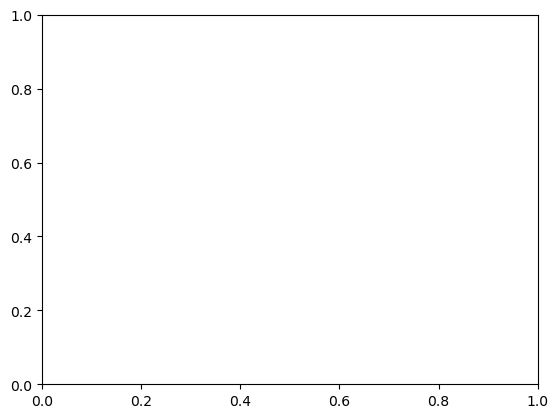

In [30]:
# line plot of observed vs predicted
pyplot.plot(X_test)
pyplot.plot(predictions)
pyplot.show()